<img src="./img/logos_combined.png" align="right" width="50%"></img>
<br><br><br>

# Geospatial data workflow
## Guided challenge

<hr>

<a href="./01_geospatial_data_workflow_stepbystep.ipynb"><< 01-Geospatial Data Workflow - Step by Step Guide</a>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space>&nbsp;<space> <a href="./jupyter_notebooks_for_geospatial_data_analysis_tutorial.ipynb">Index >></a>

# The Challenge
## Calculate global monthly anomalies of surface temperature

The climate is an indicator how the atmosphere behaves over a relatively long period of time. A climate scientist analysing climate change is therefore interested in changes in long-term averages of daily weather.

A climate scientist is e.g. interested how the average surface temperature of one specific month, e.g. October 2014, behaved compared to a long-term average for the month October. This helps a climate scientist to identify imbalances and anomalies of the state of the atmosphere.

The graphs below help a climate scientist to communicate climate change to policy- and decision-makers and the general public.

<img src="./img/global_average.png" align="rigth" width="70%"></img>
<img src="./img/global_anomaly_field.png" align="centre" width="100%"></img>


## Objective

(1) Retrieve the time series of global monthly averages of surface temperature relative to the climate normal period Jan 1981- Dec 2010

(2) Create maps of monthly surface air temperature anomalies relative to the 1981-2010 average

## Data required

* <b>ERA-Interim reanalysis</b> 2m air temperature from 1 January 1979 to 31 December 2014
* <b>Format:</b> GRIB
* <b>Spatial resolution:</b> Lat/Lon grid, 0.5 x 0.5 degrees, 720 x 361 gridpoints
* <b>Temporal resolution:</b> 6-hourly
* <b>Data volume:</b> 27 GB

## Proposed Workflow

* (1) Retrieve a time-series of global monthly averages from a WCS server and store them into a Python list
* (2) Retrieve global monthly average fields from a WCS server and store them into a raster stack
* (3) Create for every month a long-term average (global mean and fields) based on the period Jan 1981 to Dec 2010
* (4) Calculate monthly anomalies relative to the long-term (1981-2010) average
* (5) Plot and animate the results

<hr>

<img src="./img/access_button.png" align="left" width="10%"></img>

## <a id="geospatial_dataaccess"></a>Part I: Geospatial Data Access / Processing

#### Load required libraries

In [1]:
%matplotlib inline
import requests
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import gridspec
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.image as mpimg
from IPython.display import HTML
import collections
from owslib.wms import WebMapService

### (1) Retrieve a time-series of global monthly averages from a WCS server

In [2]:
url_fmt = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
          '&request=ProcessCoverages' \
          '&query=for c in (%s) return encode(avg(c[ansi("%s":"%s")] - 273.15), "csv")'

#### Create helper lists for handling datetime objects

In [3]:
# A list for every first day in the month from Jan 1979 to Dec 2014
startDateList = (range(432))
x =datetime(1979,1,1,0)
for i in range(0,len(startDateList)):
    startDateList[i]=x
    x=(x.replace(day=1)+timedelta(days=31)).replace(day=1)

# A list with every last day of the month from Jan 1979 to Dec 2014
endDateList = (range(432))
for i in range(0, len(endDateList)):
    y = startDateList[i].replace(hour=18) + relativedelta(day=31)
    endDateList[i]=y

startDateListISO=(range(432))
for i in range(0,len(startDateListISO)):
    startDateListISO[i]=startDateList[i].date().isoformat()

Go through the helper lists and retrieve for every month the monthly global mean of 2m air temperature and append a list of monthly global means.

In [4]:
monthlyAvgTS = []
for i,j in zip(startDateList,endDateList):
    url = url_fmt % ("temp2m", i.isoformat(),j.isoformat())
    r= requests.get(url,
                proxies={'http':None}
                )

    r.raise_for_status()
    y= [float(a) for a in r.text[1:-1].split(",")]
    monthlyAvgTS.append(y[0])

In [5]:
 monthlyAvgTS

[3.619025,
 2.227256,
 2.868785,
 3.878359,
 5.634751,
 7.158366,
 7.157763,
 7.103286,
 6.331698,
 4.986968,
 4.38573,
 4.36766,
 3.874061,
 3.373082,
 3.272489,
 4.270118,
 6.325368,
 7.342869,
 8.003779,
 7.515294,
 6.229942,
 5.115297,
 4.373642,
 3.973604,
 4.074201,
 3.501982,
 3.442353,
 4.312838,
 6.022644,
 7.477353,
 7.922552,
 7.737829,
 6.266415,
 5.101736,
 4.406706,
 4.22956,
 3.339037,
 3.019835,
 2.525819,
 3.664654,
 5.723108,
 7.179272,
 7.744385,
 7.120144,
 5.963474,
 4.984705,
 4.383239,
 4.369952,
 3.710006,
 3.07325,
 3.340933,
 4.093949,
 6.225007,
 7.20026,
 7.328775,
 7.484318,
 6.414767,
 4.869282,
 4.221432,
 3.948565,
 3.905883,
 3.047092,
 3.094261,
 3.838649,
 6.179036,
 6.996382,
 7.598663,
 7.239283,
 6.284831,
 5.08104,
 4.221528,
 4.010931,
 3.812514,
 2.575555,
 2.72007,
 3.867321,
 5.597936,
 7.441766,
 7.358609,
 7.368095,
 6.047092,
 4.778491,
 4.262525,
 4.137369,
 3.489452,
 3.389835,
 2.883675,
 4.019698,
 5.83303,
 7.026829,
 7.548456,
 7.2230

<div class="alert alert-success">
The Python list <b>monthlyAvgTS</b> contains for every month for the period January 1979 to December 2014 the global monthly average surface temperature in degree Celsius.
</div>

### (2) Retrieve global monthly average fields from a WCS server and store the into a multi-dimensional numpy array.

The query takes advantage of the WCPS condenser function, that is able to condense a 3D raster stack into its 2D average.

In [6]:
url_fmt_field = 'http://earthserver.ecmwf.int/rasdaman/ows?service=WCS&version=2.0.1' \
    '&request=ProcessCoverages&' \
    'query=for c in (%s) return encode((condense + over $x x(imageCrsDomain(c[Lat(%f:%f), Long(%f:%f),ansi("%s":"%s")], ansi)) using c[ansi($x)]/%d)-273.15, "csv")'

Create a raster stack of all global fields of monthly surface temperature averages

In [7]:
monthlyStackGlobal = np.empty((361,720,432))
k = 0
for i,j in zip(startDateList,endDateList):
    slices = j.day*4
    url = url_fmt_field % ("temp2m", -90,90,-180,179.5, i.isoformat(),j.isoformat(), slices)
    r= requests.get(url,
                proxies={'http':None}
                )

    r.raise_for_status()
    x = np.array(eval(r.text.replace('{','[').replace('}',']')))
    monthlyStackGlobal[:,:,k] = x.transpose()
    k = k+1

<div class="alert alert-success">
The Python list <b>monthlyStackGlobal</b> contains for every month for the period January 1979 to December 2014 the global field of monthly average surface temperature in degree Celsius.
</div>

<hr>

<img src="./img/processing_button.png" align="left" width="10%"></img>

## <a id="geospatial_dataprocessing"></a>Part II: Geospatial Data Processing

### (3) Create for every month a long-term average (global mean and fields) based on the period Jan 1981 to Dec 2010

#### (3.1) Create long-term monthly means of the global fields

In [8]:
# Subset the raster stack for fields of the normal period between 1981 to 2010 and create an average for every month based on the normal period.
monthlyStackNP = monthlyStackGlobal[:,:,24:383]
monthlyMeansStack = np.empty((361,720,12))
for i in range(0,12):
    month = monthlyStackNP[:,:,i::12]
    monthlyMeansStack[:,:,i] = np.mean(month, axis=2)

In [9]:
# Extend the raster stack of monthly averages to the length of the time series --> Duplication by 35
monthlyMeansStackNP = monthlyMeansStack
for i in range(0,35):
    monthlyMeansStackNP = np.concatenate((monthlyMeansStackNP,monthlyMeansStack), axis=2)

#### (3.2) Create long-term monthly means of the global average surface temperature

In [10]:
b1 = '1981-01-01'
b2 = '2010-12-01'

combinedList = dict(zip(startDateListISO,monthlyAvgTS))
normalPeriodDict = {k: v for k, v in combinedList.items() if k >= b1 and k <= b2}

listA = []
for key, value in sorted(normalPeriodDict.items()):
    temp = [key, value]
    listA.append(temp)

In [11]:
normalPeriodList = []
for i in range (0,12):
    x1,x2 = zip(*listA[i::12])
    t = np.mean(x2)
    normalPeriodList.append(t)
    
normalPeriodList_long =normalPeriodList *36

### (4) Calculate monthly anomalies relative to the long-term (1981-2010) average

In [12]:
finalList=[]
for i,j in zip(monthlyAvgTS,normalPeriodList_long):
    finalList.append(i-j)

# Subtract the long-term monthly averages from the monthly values
finalStack = monthlyStackGlobal - monthlyMeansStackNP

<div class="alert alert-success">
<b>finalList</b> is the final list that contains the deviations of global surface temperature deviations from the longterm average for the period 1981-2010. <br>

The n-dimensional array <b>finalStack</b> is the ifnal stack of global fields of 2m air temperature deviations relative to the normal period 1981-2010.
</div>

<hr>

<img src="./img/visualisation_button.png" align="left" width="10%"></img>

## <a id="geospatial_dataviz"></a>Part III: Geospatial Data Visualisation

### (5) Plot and animate the results

Helper functions in order to differentiate between negative and positive time-series values

In [13]:
posVals =range(0,len(finalList))
negVals =range(0,len(finalList))
for i in range(0,len(finalList)):
    if finalList[i] <0:
        posVals[i]=0
        negVals[i]=finalList[i]
    else:
        posVals[i]=finalList[i]
        negVals[i]=0

#### (5.1) Plot the time-series values (finaList) of monthly anomalies of surface temperature relative to the normal period 1981-2010

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


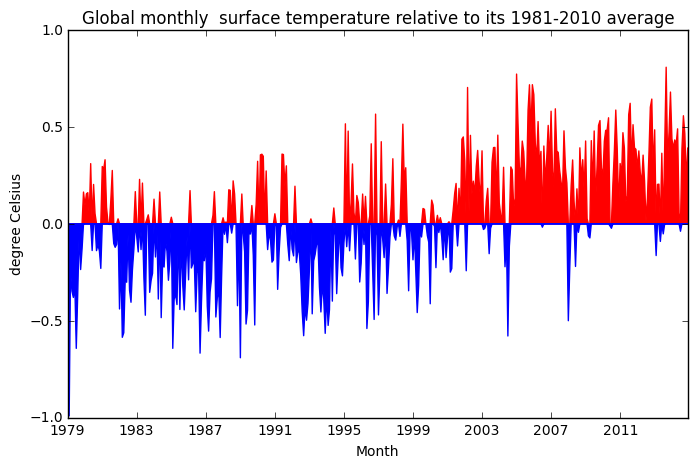

In [14]:
fig = plt.figure(figsize=(8,5))
ax = plt.axes(xlim=(startDateList[0], startDateList[431]), ylim=(-1, 1))
plt.title("Global monthly  surface temperature relative to its 1981-2010 average")
ax.set_xlabel('Month')
ax.set_ylabel('degree Celsius')
ax.fill_between(startDateList, 0,posVals,color="red")
ax.fill_between(startDateList, negVals, 0,color="blue")
plt.show()
fig.savefig('global_average.eps', format='eps', dpi=300)

#### (5.2) Plot the global fields of monthly deviations relative to the average surface temperature between 1981-2010

For a 2-dimensioanl global field, it is helpful to have country borders for the final map. This helps to better interpret the data. ECMWF provides a Web Mapping Service (WMS) with open accessible data. A Web Mapping Service allows the retrieval of data in image formats, such as PNG of JPEG.

ECMWF's WMS server offers a layer called 'foreground' with country border lines. The image can be used to plot on top of the 2D-field.

In [15]:
wms = WebMapService('http://apps.ecmwf.int/wms/?token=public', version='1.1.1')
#List all the layers available on the WMS
list((wms.contents))

def getMap(layerName,bbox):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layerName],
                 size=(600,300),
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 transparent=True)

    tmpfile = open('tmpfile.png','wb')
    tmpfile.write(img.read())
    tmpfile.close()
getMap('foreground',(-180,-90,180,90))

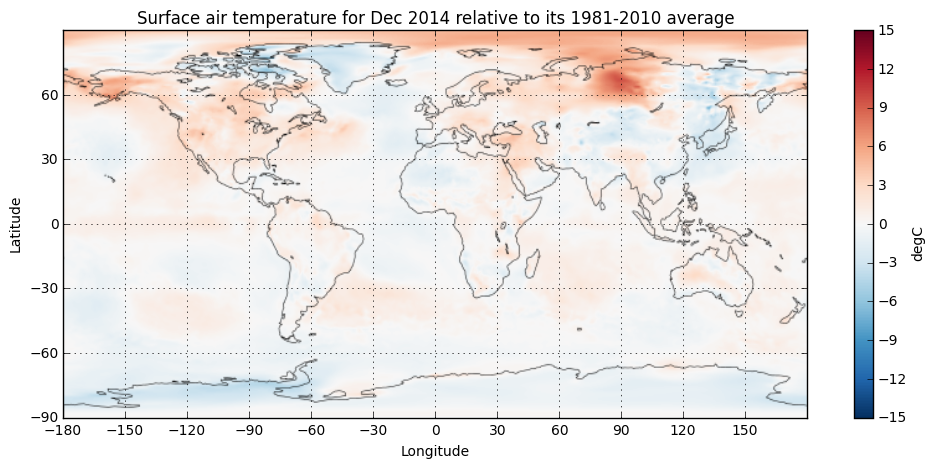

In [16]:
fig = plt.figure(figsize=(12,5))

my_cmap = plt.get_cmap('RdBu_r')
image=mpimg.imread('tmpfile.png')

### the slice of the finalStack identifies the month and year
img1=plt.imshow(finalStack[:,:,431], cmap=my_cmap, extent=[-180,180,-90,90],vmin=-15, vmax=15, aspect='auto')
img2=plt.imshow(image,extent=[-180,180,-90,90],aspect='auto')

cb = fig.colorbar(img1)
cb.set_label('degC', labelpad=5, y=0.45)

plt.grid(True)
plt.xticks(np.arange(-180,180,30))
plt.yticks(np.arange(-90,90,30))
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Surface air temperature for " + startDateList[431].strftime("%b %Y") + " relative to its 1981-2010 average")

plt.show()
fig.savefig('global_anomaly_field.eps', format='eps', dpi=300)

#### (5.3) Combine both plots and animate the time-series of monthly anomalies from Jan 1979 to Dec 2014 (with matplotlib package animation)

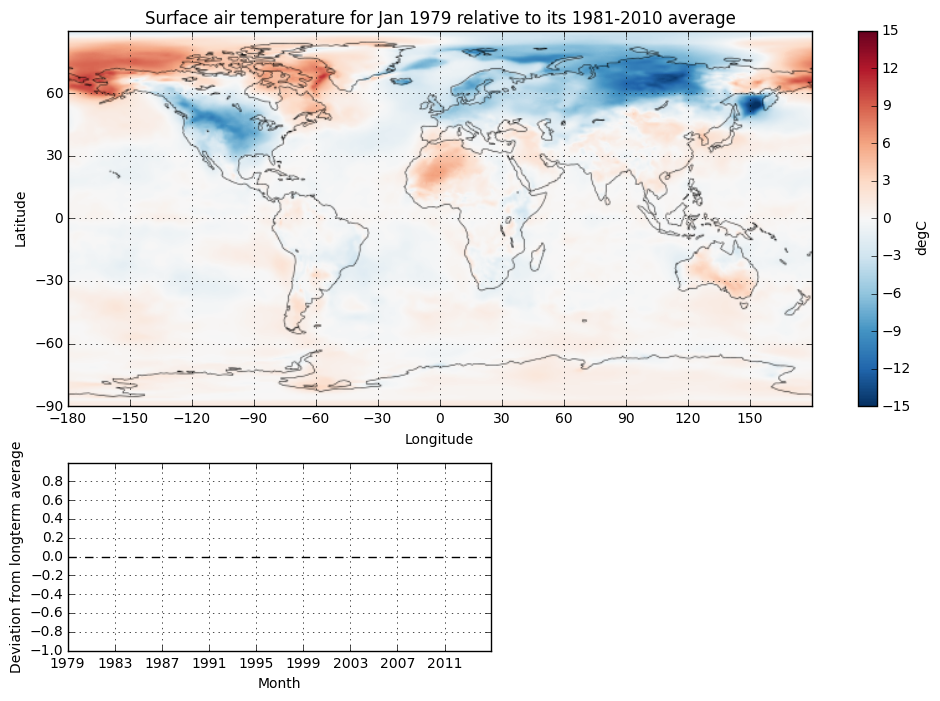

In [17]:
# Plot the global fields of monthly deviations relative to the average surface temperature between 1981-2010
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2,2, height_ratios=[2,1])
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :-1])
my_cmap =plt.get_cmap('RdBu_r')

# The country borders are at best dynamically fetched from ECMWF's WMS server
image=mpimg.imread('tmpfile.png')

# Define the type of plot
img = ax1.imshow(finalStack[:,:,i], cmap=my_cmap, extent=[-180,180,-90,90],vmin=-15, vmax=15,aspect='auto')
img1 = ax1.imshow(image,extent=[-180,180,-90,90],aspect='auto')

# Add a colorbar and label it
cb = fig.colorbar(img,ax=ax1,orientation='vertical')
cb.set_label('degC', labelpad=5, y=0.45)

# Customize the plot with labels and tick marks
ax1.grid(True)
ax1.set_xticks(np.arange(-180,180,30))
ax1.set_yticks(np.arange(-90,90,30))
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

ax2.set_xlim(startDateList[0], startDateList[431])
ax2.set_ylim(-1, 1)
line1, = ax2.plot([],[])
line2, = ax2.plot([],[])

ax2.axhline(y=0,linewidth=1, color='k', linestyle='dashed' )
ax2.grid(True)
ax2.set_yticks(np.arange(-1,1,0.2))
ax2.set_xlabel("Month")
ax2.set_ylabel("Deviation from longterm average")
        
# Function to initiate the plot for the animation
def init():
    img.set_data()
    line1.set_data([], [])
    line2.set_data([], [])
    return [img], line1, line2, 


# Function that actually animates the plot
def animate(i):
    x = startDateList[:i]
    y1 =posVals[:i]
    y2 = negVals[:i]
    line1.set_data(x, y1)
    line1.set_color('r')
    line2.set_data(x, y2)
    line2.set_color('b')
    img.set_array(finalStack[:,:,i])
    ax1.set_title("Surface air temperature for " + startDateList[i].strftime("%b %Y") + " relative to its 1981-2010 average")
    return line1, line2, [img] 

# Animation
anim = animation.FuncAnimation(fig, animate, frames=432, interval=300)

#### (5.4) Play the animation as video

In [19]:
HTML(anim.to_html5_video())

AttributeError: 'FuncAnimation' object has no attribute 'to_html5_video'

<hr>

# THANK YOU!

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>